In [1]:
!pip install mxnet

    100% |████████████████████████████████| 27.1MB 1.1MB/s 
    100% |████████████████████████████████| 61kB 20.5MB/s 
spacy 2.0.18 has requirement numpy>=1.15.0, but you'll have numpy 1.14.6 which is incompatible.
google-colab 0.0.1a1 has requirement requests~=2.18.0, but you'll have requests 2.21.0 which is incompatible.
cufflinks 0.14.6 has requirement plotly>=3.0.0, but you'll have plotly 1.12.12 which is incompatible.
  Found existing installation: requests 2.18.4
    Uninstalling requests-2.18.4:
      Successfully uninstalled requests-2.18.4
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


In [0]:
from mxnet import nd, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import datasets, transforms
from IPython import display
import matplotlib.pyplot as plt
import time

In [3]:

mnist_train = datasets.FashionMNIST(train=True)
X, y = mnist_train[0]
('X shape: ', X.shape, 'X dtype', X.dtype, 'y:', y)

('X shape: ', (28, 28, 1), 'X dtype', numpy.uint8, 'y:', 2)

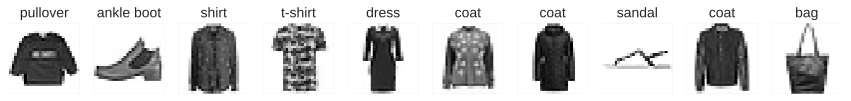

In [5]:

text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
               'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
X, y = mnist_train[0:10]
# plot images
display.set_matplotlib_formats('svg')
_, figs = plt.subplots(1, X.shape[0], figsize=(15, 15))
for f,x,yi in zip(figs, X,y):
    # 3D->2D by removing the last channel dim
    f.imshow(x.reshape((28,28)).asnumpy())
    ax = f.axes
    ax.set_title(text_labels[int(yi)])
    ax.title.set_fontsize(14)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [0]:

transformer = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.13, 0.31)])
mnist_train = mnist_train.transform_first(transformer)

In [0]:

batch_size = 256
train_data = gluon.data.DataLoader(
    mnist_train, batch_size=batch_size, shuffle=True, num_workers=4)

In [8]:
mnist_valid = gluon.data.vision.FashionMNIST(train=False)
valid_data = gluon.data.DataLoader(
    mnist_valid.transform_first(transformer),
    batch_size=batch_size, num_workers=4)

In [0]:
net = nn.Sequential()
net.add(nn.Conv2D(channels=6, kernel_size=5, activation='relu'),
        nn.MaxPool2D(pool_size=2, strides=2),
        nn.Conv2D(channels=16, kernel_size=3, activation='relu'),
        nn.MaxPool2D(pool_size=2, strides=2),
        nn.Flatten(),
        nn.Dense(120, activation="relu"),
        nn.Dense(84, activation="relu"),
        nn.Dense(10))
net.initialize(init=init.Xavier())

In [0]:
softmax_cross_entropy = gluon.loss.SoftmaxCrossEntropyLoss()

In [0]:
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.1})

In [0]:
def acc(output, label):
    # output: (batch, num_output) float32 ndarray
    # label: (batch, ) int32 ndarray
    return (output.argmax(axis=1) ==
            label.astype('float32')).mean().asscalar()

In [13]:
for epoch in range(10):
    train_loss, train_acc, valid_acc = 0., 0., 0.
    tic = time.time()
    for data, label in train_data:
        # forward + backward
        with autograd.record():
            output = net(data)
            loss = softmax_cross_entropy(output, label)
        loss.backward()
        # update parameters
        trainer.step(batch_size)
        # calculate training metrics
        train_loss += loss.mean().asscalar()
        train_acc += acc(output, label)
    # calculate validation accuracy
    for data, label in valid_data:
        valid_acc += acc(net(data), label)
    print("Epoch %d: loss %.3f, train acc %.3f, test acc %.3f, in %.1f sec" % (
            epoch, train_loss/len(train_data), train_acc/len(train_data),
            valid_acc/len(valid_data), time.time()-tic))

Epoch 0: loss 0.856, train acc 0.692, test acc 0.825, in 19.7 sec
Epoch 1: loss 0.467, train acc 0.825, test acc 0.848, in 19.8 sec
Epoch 2: loss 0.404, train acc 0.851, test acc 0.866, in 20.0 sec
Epoch 3: loss 0.368, train acc 0.864, test acc 0.871, in 19.9 sec
Epoch 4: loss 0.339, train acc 0.875, test acc 0.875, in 19.9 sec
Epoch 5: loss 0.322, train acc 0.882, test acc 0.884, in 20.2 sec
Epoch 6: loss 0.307, train acc 0.886, test acc 0.891, in 20.3 sec
Epoch 7: loss 0.295, train acc 0.891, test acc 0.888, in 20.1 sec
Epoch 8: loss 0.284, train acc 0.895, test acc 0.892, in 19.8 sec
Epoch 9: loss 0.276, train acc 0.898, test acc 0.897, in 19.8 sec


In [0]:
net.save_parameters('net.params')